In [41]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

dataset_dir = 'SameCompanySameSignal/dataset'

# DEC Dataset Introduction

In [42]:
DEC = pd.read_csv(f'{dataset_dir}/DEC.csv')

In [43]:
earnings_basic_columns = ['sector', 'ticker', 'id', 'day_earnings', 'report_end_date',
                          'beforeAfterMarket', 'year', 'quarter', 'num_available_historical_earnings']

```
Earnings ID Format
Each earnings record is uniquely identified by the id column, following the pattern:
{ticker}_{year}_{quarter}_{date}

Example:
AAPL_2019_Q1_20190129 represents Apple’s (AAPL) Q1 2019 earnings announcement, which occurred on January 29, 2019.
```

In [44]:
DEC.iloc[0]['id']

'AAPL_2019_Q1_20190129'

```
Accessing Earnings Call Transcripts
Earnings call content is stored in the DEC2019 JSON file for efficient access.

Why JSON?
Performance: Reading transcripts from individual .txt files requires ~1800 separate I/O operations (slow).

Optimization: The JSON format allows instant access to all transcripts in a single lookup.

Usage Example:
DEC2019['AAPL_2019_Q1_20190129']  
Returns the full earnings call transcript for Apple’s Q1 2019 earnings (announced on January 29, 2019).
```

**Please download the json file via Google Drive**

In [50]:
DEC2019 = json.load(open('DEC.json'))

In [51]:
DEC2019['AAPL_2019_Q1_20190129'][:197]



```
Columns following the pattern p_{direction}_{i} represent daily percentage returns (calculated using pct_change) for specific trading days relative to an earnings announcement date.

Definitions:
p_past_i
The daily return i days before the earnings announcement.
Example:
p_past_1 = 1 trading day before earnings
p_past_5 = 5 trading days before earnings

p_future_i
The daily return i days after the earnings announcement.
Example:
p_future_1 = 1 trading day after earnings
p_future_3 = 3 trading days after earnings
```



```
Example: AAPL Q1 2019 Earnings Returns
Earnings Announcement:

Date: January 29, 2019 (after market close).
ID: AAPL_2019_Q1_20190129

Daily Returns:
p_past_1 (1 trading day before earnings):
Date: 2019-01-29
Return: -1.036% (-0.010364)

p_future_1 (1 trading day after earnings):
Date: 2019-01-30
Return: +6.834% (+0.068335)
```

In [54]:
daily_return_columns = [c for c in DEC.columns if c.startswith('p_')]

In [55]:
DEC.loc[DEC['id'] == 'AAPL_2019_Q1_20190129'][['beforeAfterMarket', 'day_earnings', 'p_past_1', 'p_future_1']]

,beforeAfterMarket,day_earnings,p_past_1,p_future_1
0,AfterMarket,2019-01-29,-0.010364,0.068335


In [57]:
# (36.89 -	37.28) / 37.28, (39.42 -	36.89) / 36.89



```
Column Naming Convention for Log Volatility (lv)
Columns following the pattern lv{window}_{direction}_{i} represent the log volatility (standard deviation of log returns over a specified window) for a given trading period relative to an earnings announcement.

Definitions:
lv{window}_past_i
The log volatility ending i days before the earnings announcement, calculated over a rolling {window}-day period.
Example:
lv3_past_3 = 3-day volatility ending 3 trading days before earnings
lv10_past_1 = 10-day volatility ending 1 trading day before earnings

lv{window}_future_i
The log volatility ending i days after the earnings announcement, calculated over a rolling {window}-day period.
Example:
lv3_future_3 = 3-day volatility ending 3 trading days after earnings
lv7_future_1 = 7-day volatility ending 1 trading day after earnings
```


In [58]:
volatility_columns = [c for c in DEC.columns if c.startswith('lv')]

In [59]:
DEC.loc[DEC['id'] == 'AAPL_2019_Q1_20190129'][['beforeAfterMarket', 'day_earnings', 'p_future_1', 'p_future_2', 'p_future_3', 'lv3_future_3']]

,beforeAfterMarket,day_earnings,p_future_1,p_future_2,p_future_3,lv3_future_3
0,AfterMarket,2019-01-29,0.068335,0.007199,0.000481,-3.489151


In [61]:
# np.log(np.std([0.068335,	0.007199,	0.000481]))

In [47]:
stpev_columns = [c for c in DEC.columns if c.startswith('stpev')]

# historical_earnings_columns = [c for c in DEC.columns if c.startswith('day_historical_') and c.endswith('_earnings_EOD')]

In [62]:
DEC.iloc[19][['id', 'num_available_historical_earnings', 'stpev_mean_lv3f3']], np.mean(DEC.iloc[:19]['lv3_future_3'])

(id                                   AAPL_2023_Q4_20231102
 num_available_historical_earnings                       19
 stpev_mean_lv3f3                                 -3.905933
 Name: 19, dtype: object,
 np.float64(-3.905933132377221))



```
Column Naming Convention for Category Splitting with Rolling Test Strategy
Columns following the pattern rolling_test_on_{fiscal_year}_{fiscal_quarter}_cate indicate the dataset category assignment (train, val, or test) when evaluating earnings from a specific fiscal quarter, using a rolling window approach that prevents look-ahead bias.

Definitions:
rolling_test_on_{fiscal_year}_{fiscal_quarter}_cate
Specifies the category for each earnings announcement when the test set consists of earnings from the specified {fiscal_year} and {fiscal_quarter}.

Possible values:
train: Training data (≈67% of historical data)
val: Validation data (≈33% of historical data)
test: Current evaluation quarter
None: Future data (excluded to prevent look-ahead bias)

Splitting Strategy:
Test Set:
Contains only earnings from the specified {fiscal_year}_{fiscal_quarter}

Training/Validation Sets:
All earnings before the test quarter are randomly split:
2:1 ratio → train (67%) vs. val (33%)

Future Data Handling:
Earnings after the test quarter are marked as None
Ensures no future information leaks into model evaluation

Examples:
Column Name	Description
rolling_test_on_2022_first_cate	Category assignment when testing on 2022 Q1 earnings
rolling_test_on_2023_third_cate	Category assignment when testing on 2023 Q3 earnings
```



In [49]:
rolling_test_cate_columns = [c for c in DEC.columns if c.startswith('rolling_test') and c.endswith('cate')]

In [64]:
import matplotlib.cm as cm


def plot_cate_splitting(df, cate_columns, x_column='day_earnings'):
    """
    Plots all categories in a single plot with different y positions for each category.

    Parameters:
    - df: pandas DataFrame containing the data
    - x_column: column name for x-axis values
    - y_column: column name indicating the categories
    """

    # Sort the DataFrame by the x_column for cleaner plots
    # df_sorted = df.sort_values(by=x_column)

    # Create a consistent color map for unique x_column values


    plt.figure(figsize=(12, 4))

    for i, col in enumerate(cate_columns):
        # Filter out rows where the value is 'none'
        filtered_data = df[df[col] != 'none']

        filtered_data = filtered_data.sort_values(by=x_column)

        unique_x_values = ['train', 'val', 'test']
        colors = cm.get_cmap('tab10')  # Access colormap
        color_map = {val: colors(i / len(unique_x_values)) for i, val in enumerate(unique_x_values)}
        if not filtered_data.empty:  # Plot only if there's valid data
            for val in unique_x_values:

                subset = filtered_data[filtered_data[col] == val]
                if not subset.empty:
                    plt.scatter(
                        subset[x_column],
                        [i] * len(subset),  # Use index `i` as y-value
                        color=color_map[val],
                        s=1  # Marker size
                    )

    # Customize the plot
    plt.xlabel(x_column)
    plt.yticks(range(len(cate_columns)), cate_columns)  # Use column names for y-ticks
    # plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Create a single legend for the colors
    handles = [plt.Line2D([0], [0], marker='o', color=color_map[val], label=val, linestyle='') for val in unique_x_values]
    plt.legend(handles=handles, title=x_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
# plot_cate_splitting(DEC, rolling_test_cate_columns[-8:])

# Run PEV, STPEV on EC and MAEC

In [32]:
def build_aug_stpev_mean(earnings_df, EOD_price_df):
    """
    Builds augmented Short-Term Post-Earnings Volatility (STPEV) mean statistics.

    Calculates historical mean volatility for different windows (3, 7, 15, 30 days)
    post-earnings, strictly avoiding look-ahead bias by using only data before
    the test period begins.

    Parameters:
    -----------
    earnings_df : DataFrame
        Contains earnings announcement data with columns:
        - 'cate': Dataset category ('test' or other)
        - 'day_earnings': Earnings announcement date
        - 'ticker': Stock ticker symbol

    EOD_price_df : DataFrame
        Contains end-of-day price data with columns:
        - 'day_earnings': Earnings announcement date
        - 'ticker': Stock ticker symbol
        - 'lv{window}_future_{window}': Log volatility columns

    Returns:
    --------
    dict
        Nested dictionary with structure:
        {
            window: {
                'pev_mean': overall mean volatility for window,
                'TICKER1': ticker-specific mean volatility,
                'TICKER2': ticker-specific mean volatility,
                ...
            }
            for window in [3, 7, 15, 30]
        }
    """

    # Initialize output dictionary
    aug_stpev_mean = {}

    # Get test period earnings
    test_earnings_df = earnings_df[earnings_df['cate'] == 'test']

    # Filter historical data to strictly avoid look-ahead bias
    min_test_date = min(test_earnings_df['day_earnings'])
    test_tickers = test_earnings_df['ticker'].to_list()

    historical_earnings_EOD_price_df = EOD_price_df[
        (EOD_price_df['day_earnings'] < min_test_date) &
        (EOD_price_df['ticker'].isin(test_tickers))
    ]

    # Calculate volatility statistics for each window
    for window in [3, 7, 15, 30]:
        aug_stpev_mean[window] = {}
        vol_column = f'lv{window}_future_{window}'

        # Calculate ticker-specific mean volatility
        by_ticker = historical_earnings_EOD_price_df.groupby('ticker')[vol_column].mean().reset_index()

        # Store overall mean volatility
        aug_stpev_mean[window]['pev_mean'] = by_ticker[vol_column].mean()

        # Store ticker-specific volatility
        for _, row in by_ticker.iterrows():
            aug_stpev_mean[window][row['ticker']] = row[vol_column]

    # Calculate and print coverage statistics
    num_test_tickers = test_earnings_df['ticker'].nunique()
    OET = round(len(historical_earnings_EOD_price_df) / num_test_tickers, 3)

    included_tickers = set(aug_stpev_mean[3].keys()) & set(test_tickers)
    coverage = len(included_tickers)

    print(f"Overlapping Earnings per Ticker (OET): {OET} "
          f"({len(historical_earnings_EOD_price_df)} / {num_test_tickers})")
    print(f"{coverage} / {num_test_tickers} tickers included in augmented dataset\n")

    return aug_stpev_mean

In [33]:
def run_pev_stpev(earnings_df, window, aug_stpev_mean):
    """
    Calculate and compare volatility prediction errors using different mean estimators.

    Computes Mean Squared Error (MSE) for four approaches:
    1. Overall historical mean (pev_mean)
    2. Ticker-specific historical mean (stpev_mean)
    3. Augmented overall mean (aug_pev_mean)
    4. Augmented ticker-specific mean (aug_stpev_mean)

    Parameters:
    -----------
    earnings_df : DataFrame
        DataFrame containing earnings data with columns:
        - 'cate': Dataset category ('test' or other)
        - 'ticker': Stock ticker symbol
        - f'future_{window}': Future volatility column for given window

    window : int
        The prediction window size (e.g., 3, 7, 15, 30 days)

    aug_stpev_mean : dict
        Dictionary containing augmented volatility means from build_aug_stpev_mean()

    Returns:
    --------
    tuple
        (pev_mean_mse, stpev_mean_mse, aug_pev_mean_mse, aug_stpev_mean_mse)
        Mean Squared Errors for each estimation approach
    """

    volatility_column = f'future_{window}'

    # Split data into test and historical sets
    test_earnings_df = earnings_df[earnings_df['cate'] == 'test'].copy()
    historical_earnings_df = earnings_df[earnings_df['cate'] != 'test']

    # Calculate baseline volatility means
    pev_mean = round(historical_earnings_df[volatility_column].mean(), 6)
    test_earnings_df['pev_mean'] = pev_mean
    test_earnings_df['aug_pev_mean'] = aug_stpev_mean[window]['pev_mean']

    def get_stpev_mean(non_test_df, ticker, fallback_mean):
        """Get ticker-specific mean volatility with fallback to overall mean"""
        if ticker in non_test_df['ticker'].unique():
            return round(non_test_df[non_test_df['ticker'] == ticker][volatility_column].mean(), 6)
        return fallback_mean

    # Calculate ticker-specific means
    test_earnings_df['stpev_mean'] = test_earnings_df['ticker'].apply(
        lambda x: get_stpev_mean(historical_earnings_df, x, pev_mean)
    )

    test_earnings_df['aug_stpev_mean'] = test_earnings_df.apply(
        lambda x: aug_stpev_mean[window].get(x['ticker'], pev_mean),
        axis=1
    )

    # Print coverage statistics for window=3
    if window == 3:
        num_test_tickers = test_earnings_df['ticker'].nunique()
        OET = round(len(historical_earnings_df) / num_test_tickers, 3)
        earnings_use_stpev = len(test_earnings_df[test_earnings_df['stpev_mean'] != pev_mean])

        print(f"Overlapping Earnings per Ticker (OET): {OET} "
              f"({len(historical_earnings_df)} / {num_test_tickers}) in original dataset")
        print(f"{earnings_use_stpev} / {num_test_tickers} tickers have ticker-specific estimates\n")

    # Calculate Mean Squared Errors
    def calculate_mse(true_col, pred_col):
        return round(np.mean((test_earnings_df[true_col] - test_earnings_df[pred_col]) ** 2), 3)

    pev_mean_mse = calculate_mse(volatility_column, 'pev_mean')
    stpev_mean_mse = calculate_mse(volatility_column, 'stpev_mean')
    aug_pev_mean_mse = calculate_mse(volatility_column, 'aug_pev_mean')
    aug_stpev_mean_mse = calculate_mse(volatility_column, 'aug_stpev_mean')

    return pev_mean_mse, stpev_mean_mse, aug_pev_mean_mse, aug_stpev_mean_mse

In [34]:
def run_EC_MAEC(dataset_dir, aug_stpev_mean):
    """
    Run Error Comparison (EC) and Mean Absolute Error Comparison (MAEC) across multiple time windows.

    Computes and compares Mean Squared Errors (MSE) for four volatility estimation methods:
    1. PEV (Plain Error Variance) - Overall historical mean
    2. STPEV (Short-Term PEV) - Ticker-specific historical mean
    3. Augmented PEV - Augmented overall mean
    4. Augmented STPEV - Augmented ticker-specific mean

    Parameters:
    -----------
    dataset_dir : str
        Path to directory containing the dataset
    aug_stpev_mean : dict
        Precomputed augmented volatility means from build_aug_stpev_mean()

    Returns:
    --------
    tuple of lists
        (pev_mses, stpev_mses, aug_pev_mses, aug_stpev_mses)
        MSE values for each method across all windows
    """

    # Initialize containers for MSE values
    method_results = {
        'PEV': [],
        'STPEV': [],
        'Aug_PEV': [],
        'Aug_STPEV': []
    }

    windows = [3, 7, 15, 30]

    # Calculate MSE for each window
    for window in windows:
        errors = run_pev_stpev(dataset_dir, window, aug_stpev_mean)
        method_results['PEV'].append(errors[0])
        method_results['STPEV'].append(errors[1])
        method_results['Aug_PEV'].append(errors[2])
        method_results['Aug_STPEV'].append(errors[3])

    # Print formatted results
    print("\nVolatility Prediction Error Comparison")
    print("=" * 60)
    print("{:<12} | {:<8} | {:<8} | {:<8} | {:<8} | {:<8}".format(
        "Method", "Mean", "3-day", "7-day", "15-day", "30-day"))
    print("-" * 60)

    for method, mses in method_results.items():
        mean_mse = round(np.mean(mses), 3)
        print("{:<12} | {:<8.3f} | {:<8.3f} | {:<8.3f} | {:<8.3f} | {:<8.3f}".format(
            method, mean_mse, mses[0], mses[1], mses[2], mses[3]))

    print("=" * 60)

    return (
        method_results['PEV'],
        method_results['STPEV'],
        method_results['Aug_PEV'],
        method_results['Aug_STPEV']
    )

In [52]:
EC_earnings = pd.read_csv(f'{dataset_dir}/EC/EC_earnings.csv')

augmented_EC_earnings_history = pd.read_csv(f'{dataset_dir}/EC/augmented_EC_earnings_history.csv')

EC_aug_stpev_mean = build_aug_stpev_mean(EC_earnings, augmented_EC_earnings_history)

results = run_EC_MAEC(EC_earnings, EC_aug_stpev_mean)

Overlapping Earnings per Ticker (OET): 19.775 (2195 / 111)
96 / 111 tickers included in augmented dataset

Overlapping Earnings per Ticker (OET): 4.027 (447 / 111) in original dataset
95 / 111 tickers have ticker-specific estimates


Volatility Prediction Error Comparison
Method       | Mean     | 3-day    | 7-day    | 15-day   | 30-day  
------------------------------------------------------------
PEV          | 0.399    | 0.743    | 0.389    | 0.262    | 0.201   
STPEV        | 0.349    | 0.724    | 0.330    | 0.205    | 0.138   
Aug_PEV      | 0.367    | 0.712    | 0.351    | 0.235    | 0.170   
Aug_STPEV    | 0.296    | 0.569    | 0.293    | 0.201    | 0.122   


In [37]:
MAEC15_earnings = pd.read_csv(f'{dataset_dir}/MAEC/MAEC15_earnings.csv')
MAEC15_earnings['day_earnings'] = MAEC15_earnings['time']

augmented_MAEC15_earnings_history = pd.read_csv(f'{dataset_dir}/MAEC/augmented_MAEC15_earnings_history.csv')

MAEC15_aug_stpev_mean = build_aug_stpev_mean(MAEC15_earnings, augmented_MAEC15_earnings_history)

results = run_EC_MAEC(MAEC15_earnings, MAEC15_aug_stpev_mean)

Overlapping Earnings per Ticker (OET): 20.727 (3192 / 154)
142 / 154 tickers included in augmented dataset

Overlapping Earnings per Ticker (OET): 3.968 (611 / 154) in original dataset
68 / 154 tickers have ticker-specific estimates


Volatility Prediction Error Comparison
Method       | Mean     | 3-day    | 7-day    | 15-day   | 30-day  
------------------------------------------------------------
PEV          | 0.305    | 0.532    | 0.301    | 0.209    | 0.177   
STPEV        | 0.301    | 0.571    | 0.273    | 0.190    | 0.170   
Aug_PEV      | 0.283    | 0.514    | 0.271    | 0.188    | 0.157   
Aug_STPEV    | 0.225    | 0.443    | 0.214    | 0.130    | 0.112   


In [38]:
MAEC16_earnings = pd.read_csv(f'{dataset_dir}/MAEC/MAEC16_earnings.csv')
MAEC16_earnings['day_earnings'] = MAEC16_earnings['time']

augmented_MAEC16_earnings_history = pd.read_csv(f'{dataset_dir}/MAEC/augmented_MAEC16_earnings_history.csv')

MAEC16_aug_stpev_mean = build_aug_stpev_mean(MAEC16_earnings, augmented_MAEC16_earnings_history)

results = run_EC_MAEC(MAEC16_earnings, MAEC16_aug_stpev_mean)

Overlapping Earnings per Ticker (OET): 18.17 (5033 / 277)
260 / 277 tickers included in augmented dataset

Overlapping Earnings per Ticker (OET): 4.043 (1120 / 277) in original dataset
160 / 277 tickers have ticker-specific estimates


Volatility Prediction Error Comparison
Method       | Mean     | 3-day    | 7-day    | 15-day   | 30-day  
------------------------------------------------------------
PEV          | 0.230    | 0.380    | 0.229    | 0.173    | 0.139   
STPEV        | 0.271    | 0.459    | 0.273    | 0.209    | 0.144   
Aug_PEV      | 0.229    | 0.369    | 0.239    | 0.168    | 0.139   
Aug_STPEV    | 0.247    | 0.470    | 0.238    | 0.168    | 0.113   


# Run PEV, STPEV on DEC

In [18]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def display_rolling_test_results(DEC, rolling_test_cate_columns):
    """
    Display rolling test results in a structured quarterly format with MSE metrics,
    including a single yearly average column.

    Parameters:
    -----------
    DEC : DataFrame
        Dataset containing volatility predictions and actuals
    rolling_test_cate_columns : list
        List of column names following 'rolling_test_on_{year}_{quarter}_cate' pattern

    Returns:
    --------
    Styled DataFrame
        Formatted results with years as rows, quarters as sub-columns, and a yearly average column
    """
    # Quarter name mapping
    QUARTER_MAP = {
        'first': 'Q1',
        'second': 'Q2',
        'third': 'Q3',
        'fourth': 'Q4'
    }

    # Initialize results storage
    results = {}
    windows = [3, 7, 15, 30]

    # Process each test period
    for cate_column in rolling_test_cate_columns:
        parts = cate_column.split('_')
        quarter = QUARTER_MAP.get(parts[-2], parts[-2].upper())
        year = parts[-3]

        test_data = DEC[DEC[cate_column] == 'test']
        quarter_results = {}

        # Calculate MSE for each window
        for window in windows:
            pred_col = f'stpev_mean_lv{window}f{window}'
            true_col = f'lv{window}_future_{window}'
            mse = round(mean_squared_error(test_data[pred_col], test_data[true_col]), 3)
            quarter_results[f'{window}-day'] = mse

        # Calculate mean MSE
        quarter_results['Mean'] = round(np.mean(list(quarter_results.values())), 3)

        # Store results
        if year not in results:
            results[year] = {}
        results[year][quarter] = quarter_results

    # Prepare DataFrame
    all_years = sorted(results.keys())
    all_quarters = ['Q1', 'Q2', 'Q3', 'Q4']
    metrics = [f'{window}-day' for window in windows] + ['Mean']

    # Create MultiIndex columns for quarters
    quarters_columns = pd.MultiIndex.from_product([all_quarters, metrics])

    # Build data array for quarterly data
    quarterly_data = []
    yearly_avgs = []

    for year in all_years:
        row = []
        all_values = []

        # Add quarter data and collect values for yearly average
        for q in all_quarters:
            if q in results[year]:
                for m in metrics:
                    value = results[year][q][m]
                    row.append(value)
                    # Only include actual window MSEs (exclude the "Mean" values) for yearly average
                    if m != 'Mean':
                        all_values.append(value)
            else:
                row.extend([None] * len(metrics))

        quarterly_data.append(row)

        # Calculate yearly average (across all quarters and all metrics)
        valid_values = [v for v in all_values if v is not None]
        if valid_values:
            yearly_avg = round(np.mean(valid_values), 3)
        else:
            yearly_avg = None
        yearly_avgs.append(yearly_avg)

    # Create the quarterly DataFrame
    quarterly_df = pd.DataFrame(quarterly_data, index=all_years, columns=quarters_columns)

    # Add yearly average column
    yearly_avg_column = pd.Series(yearly_avgs, index=all_years, name=('Yearly Avg', ''))

    # Combine into final DataFrame
    result_df = pd.concat([quarterly_df, yearly_avg_column], axis=1)


    return result_df

In [19]:
result_df = display_rolling_test_results(DEC, rolling_test_cate_columns)
result_df

Q1                                 Q2                              \
      3-day  7-day 15-day 30-day   Mean  3-day  7-day 15-day 30-day   Mean   
2019    NaN    NaN    NaN    NaN    NaN  0.902  0.442  0.198  0.118  0.415   
2020  0.725  0.477  0.695  1.370  0.817  0.786  0.383  0.346  0.237  0.438   
2021  0.368  0.149  0.067  0.041  0.156  0.463  0.209  0.150  0.173  0.249   
2022  0.584  0.245  0.152  0.099  0.270  0.640  0.270  0.201  0.129  0.310   
2023  0.611  0.180  0.093  0.074  0.239  0.601  0.209  0.122  0.081  0.253   

      ...     Q3                          Q4                              \
      ...  7-day 15-day 30-day   Mean  3-day  7-day 15-day 30-day   Mean   
2019  ...  0.295  0.159  0.105  0.299  0.523  0.265  0.181  0.119  0.272   
2020  ...  0.196  0.112  0.083  0.269  0.536  0.275  0.281  0.151  0.311   
2021  ...  0.353  0.260  0.196  0.333  0.536  0.177  0.114  0.062  0.222   
2022  ...  0.219  0.104  0.057  0.243  0.599  0.236  0.183  0.095  0.278   
2023  ...  0.215  0.132  0.130  0.227  0.520  0.215  0.133  0.118  0.246   

     Yearly Avg  
                 
2019      0.329  
2020      0.459  
2021      0.240  
2022      0.275  
2023      0.242  

[5 rows x 21 columns]

# Embedding-Level Analysis

In [16]:
from typing import Tuple
from sklearn.metrics.pairwise import cosine_similarity


def load_embeddings(npz_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load embeddings and IDs from .npz file.

    Args:
        npz_path: Path to .npz file

    Returns:
        Tuple containing (embeddings, ids)
    """
    try:
        with np.load(npz_path, allow_pickle=True) as data:
            return data['embeddings'], data['ids']
    except Exception as e:
        print(f"Failed to load embeddings from {npz_path}: {str(e)}")
        raise


def calculate_group_similarity(embedding, group_embeddings):
    """Calculate the average cosine similarity between an embedding and a group of embeddings.

    Args:
        embedding: The target embedding (1D array)
        group_embeddings: The group of embeddings to compare against (2D array)

    Returns:
        float: Mean cosine similarity between the target and group embeddings
    """
    similarities = cosine_similarity(embedding.reshape(1, -1), group_embeddings)
    return np.mean(similarities.flatten())


def plot_within_vs_overall_similarity(df, overall_embeddings, print_mean_only=False):
    """Compare similarity within ticker groups vs overall dataset similarity.

    Args:
        df: DataFrame containing ticker information
        overall_embeddings: All embeddings for the dataset
        print_mean_only: If True, only print means without plotting
    """
    within_ticker_similarities = []
    overall_similarities = []

    for ticker in tqdm(df['ticker'].unique(), desc="Calculating similarities"):
        ticker_mask = df['ticker'] == ticker
        ticker_embeddings = overall_embeddings[ticker_mask]

        for idx in df[ticker_mask].index:
            embedding = overall_embeddings[idx]
            within_ticker_similarities.append(
                calculate_group_similarity(embedding, ticker_embeddings)
            )
            overall_similarities.append(
                calculate_group_similarity(embedding, overall_embeddings)
            )

    # Print mean similarities rounded to 3 decimal places
    print(f"Within-ticker similarity: {np.mean(within_ticker_similarities):.3f}")
    print(f"Overall similarity: {np.mean(overall_similarities):.3f}")

    if print_mean_only:
        return

    # Create violin plot visualization
    plt.figure(figsize=(10, 6))
    plt.violinplot([within_ticker_similarities, overall_similarities])

    # Customize plot appearance
    plt.xticks(
        [1, 2],
        ['Same-ticker Group', 'All-dataset Group'],
        fontsize=14
    )
    plt.ylabel('Cosine Similarity', fontsize=14)
    plt.title('Within-Group vs Overall Similarity Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

**Please download the embeddings via Google Drive and place them under SameCompanySameSignal/dataset**

In [53]:
embedding_dir = f'{dataset_dir}/Embeddings/openai'

emb, ids = load_embeddings(f'{embedding_dir}/DEC.npz',)
random_ticker_emb, ids = load_embeddings(f'{embedding_dir}/DECRandomTicker.npz', )
random_all_emb, ids = load_embeddings(f'{embedding_dir}/DECRandomAll.npz', )

In [ ]:
plot_within_vs_overall_similarity(DEC,
                                  emb,
                                  print_mean_only=True)

Calculating similarities: 100%|██████████| 90/90 [01:50<00:00,  1.23s/it]

Within-ticker similarity: 0.891
Overall similarity: 0.722


In [ ]:
plot_within_vs_overall_similarity(DEC,
                                  random_ticker_emb,
                                  print_mean_only=True)

Calculating similarities: 100%|██████████| 90/90 [01:42<00:00,  1.14s/it]

Within-ticker similarity: 1.000
Overall similarity: 0.752


In [ ]:
plot_within_vs_overall_similarity(DEC,
                                  random_all_emb,
                                  print_mean_only=True)

Calculating similarities: 100%|██████████| 90/90 [01:44<00:00,  1.17s/it]

Within-ticker similarity: 0.764
Overall similarity: 0.752


# Prediction-Level Analysis

In [13]:
from scipy.stats import pearsonr


def pearson_analysis_stpev(df, year, embedding_type='DEC', plot=False,
                           earnings_results_dir='SameCompanySameSignal/earnings_results/TMLP'):
    TMLP_results = os.listdir(f'{earnings_results_dir}/{embedding_type}')

    # if embedding_type == 'gecko':
    #     all_TMLP_files += os.listdir('analysis/all_random_split/gecko')

    # Result containers
    years, quarters, windows, coefs, pvalues = [], [], [], [], []

    if plot:
        fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 16), constrained_layout=True)
        fig.suptitle('Scatter Plots for Pearson Correlation (Year-Quarter by Windows)', fontsize=16)
        row_index = 0

    for current_year in range(year, year + (1 if plot else 5)):  # Limit to the given year
        for quarter in ['first', 'second', 'third', 'fourth']:
            if current_year == 2019 and quarter == 'first':
                continue

            rolling_test_df = df[
                (df['year'] == year) &
                (df['quarter'] == quarter)
            ]
            file_names = [f for f in TMLP_results if f'rt({current_year}|{quarter})' in f ]

            year_quarter_coefs, year_quarter_pvalues = [], []
            for window in [3, 7, 15, 30]:
                # Filter file names for the current year, quarter, and window
                file_name = [f for f in file_names if f'win{window}_' in f]

                assert len(file_name) == 1
                file_name = file_name[0]


                tmlp_result = pd.read_csv(f'{earnings_results_dir}/{embedding_type}/{file_name}')
                tmlp_result['ticker'] = tmlp_result['id'].apply(lambda x: x.split('_')[0])

                # Merge dataframes
                merged = rolling_test_df[['ticker', f'stpev_mean_lv{window}f{window}']].merge(
                    tmlp_result[['ticker', 'preds']], on='ticker'
                )

                # Calculate Pearson correlation
                correlation, p_value = pearsonr(
                    merged[f'stpev_mean_lv{window}f{window}'],
                    merged['preds']
                )

                if plot:
                    # Scatter plot for the current combination
                    ax = axs[row_index, [3, 7, 15, 30].index(window)]
                    ax.scatter(merged[f'stpev_mean_lv{window}f{window}'], merged['preds'], alpha=0.7)
                    ax.set_title(f'Year {current_year} Quarter {quarter} Win {window}\nCorr: {correlation:.2f}', fontsize=10)
                    ax.set_xlabel(f'STPEV(Mean) (window={window})')
                    ax.set_ylabel(f'{embedding_type}')

                # Append results
                year_quarter_coefs.append(correlation)
                year_quarter_pvalues.append(p_value)

            years.append(current_year)
            quarters.append(quarter)
            windows.append([3, 7, 15, 30])
            coefs.append(year_quarter_coefs)
            pvalues.append(year_quarter_pvalues)

            if plot:
                row_index += 1

    if plot:
        plt.show()
    else:
        return {
            "years": years,
            "quarters": quarters,
            "windows": windows,
            "coefs": coefs,
            "pvalues": pvalues
        }


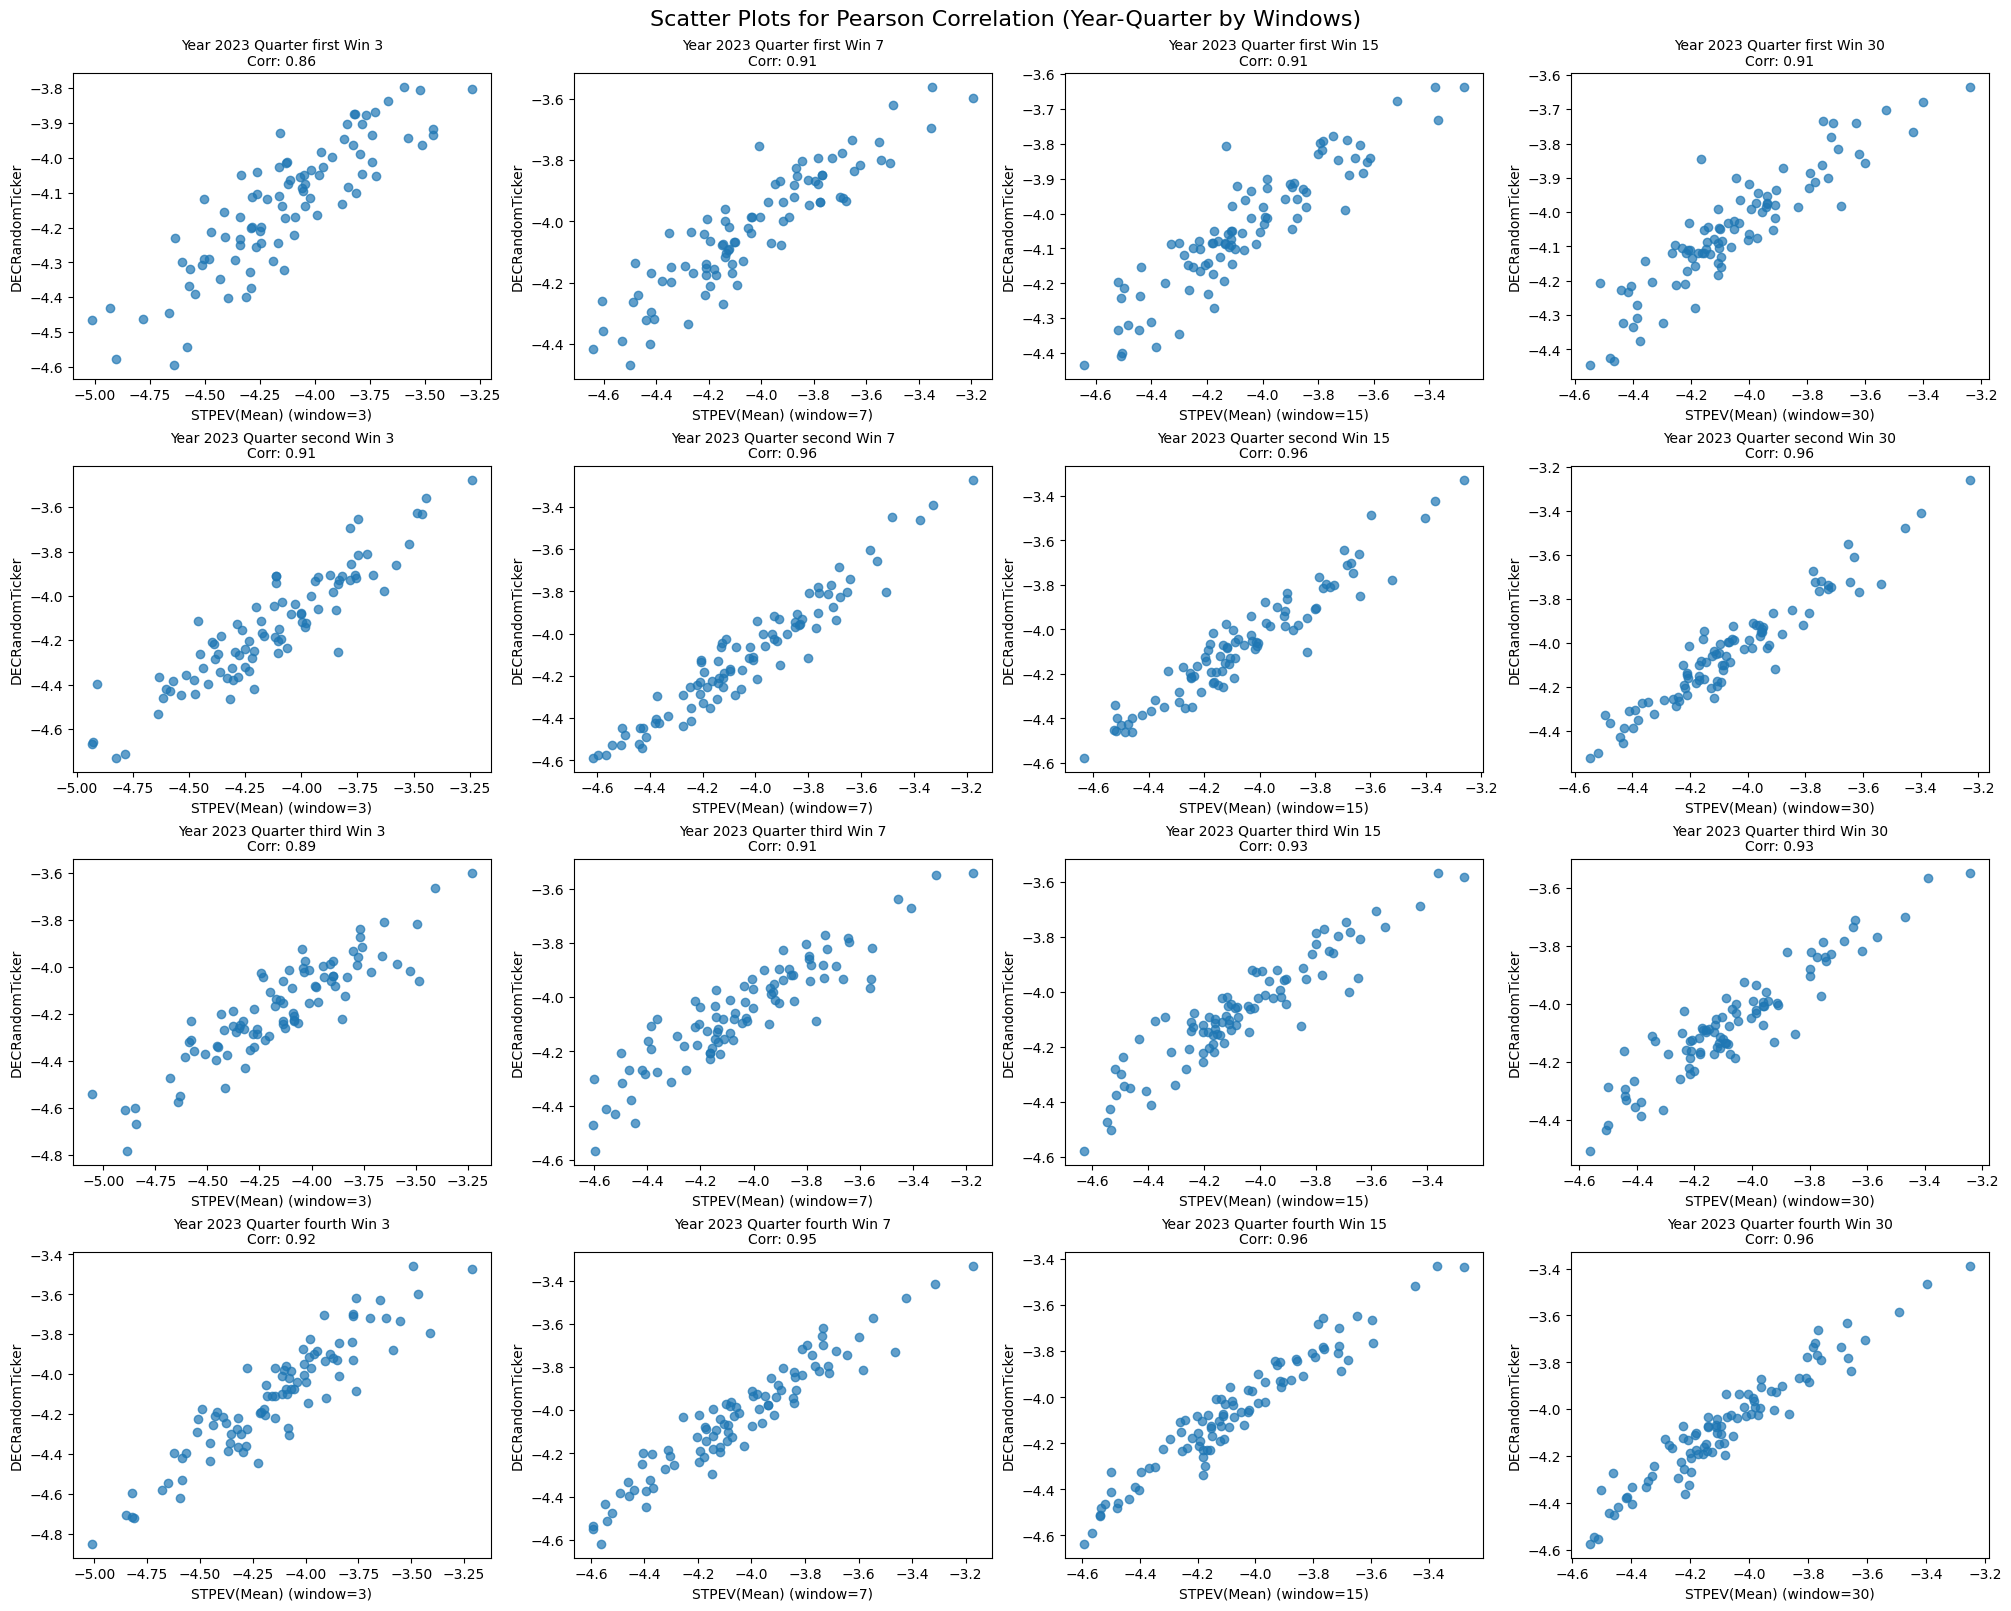

In [14]:
pearson_analysis_stpev(DEC, 2023,
                       embedding_type="DECRandomTicker", plot=True)

# Time-Series Model Analysis

In [8]:
def parse_ts_results(results_dir):
    """
    Parse TS results files from a directory and convert them to a DataFrame.

    Parameters:
    -----------
    results_dir : str
        Path to the directory containing TS result files

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the extracted information (win, year, quarter, mse)
    """
    rows = []

    for ts_result in os.listdir(results_dir):
        try:
            # Extract parts from the filename
            parts = ts_result.split('_')
            win_part = parts[3].replace('win', '')
            year_quarter_part = parts[4]
            year = year_quarter_part.split('|')[0].replace('rt(', '')
            quarter = year_quarter_part.split('|')[1].replace(')', '')
            mse = float(parts[-1].replace('.csv', ''))

            # Create row dictionary
            row = {
                'win': int(win_part),
                'year': year,
                'quarter': quarter,
                'mse': mse
            }

            rows.append(row)
        except (IndexError, ValueError) as e:
            # Skip files that don't match the expected format
            print(f"Skipping file {ts_result}: {str(e)}")
            continue

    # Create DataFrame from rows
    results_df = pd.DataFrame(rows)
    return results_df

# Example usage
ts_results_dir = 'SameCompanySameSignal/earnings_results/TSMixer'
ts_results_df = parse_ts_results(ts_results_dir)

In [9]:
def formulate_ts_results(ts_results_df):
    # Step 1: Map window values to labels and standardize quarters
    win_mapping = {3: '3-day', 7: '7-day', 15: '15-day', 30: '30-day'}
    ts_results_df['window_label'] = ts_results_df['win'].map(win_mapping)

    # Map quarter values to standardized format
    quarter_mapping = {
        'first': 'Q1', 'second': 'Q2', 'third': 'Q3', 'fourth': 'Q4',
    }
    ts_results_df['quarter_std'] = ts_results_df['quarter'].astype(str).map(quarter_mapping)

    # Handle any unmapped quarters
    if ts_results_df['quarter_std'].isna().any():
        print("Warning: Some quarter values weren't mapped.")
        print(f"Unique quarter values: {ts_results_df['quarter'].unique()}")
        # Default to original value if not mapped
        ts_results_df['quarter_std'] = ts_results_df['quarter_std'].fillna(ts_results_df['quarter'])

    # Step 2: Create a DataFrame with the modified structure (yearly avg as single column)
    # Define columns for quarters with all windows
    quarter_windows = pd.MultiIndex.from_product([
        ['Q1', 'Q2', 'Q3', 'Q4'],
        ['3-day', '7-day', '15-day', '30-day', 'Mean']
    ], names=['Quarter', 'Window'])

    # Create and add the yearly average column (just Mean)
    yearly_avg_col = pd.MultiIndex.from_tuples([('Yearly Avg', 'Mean')], names=['Quarter', 'Window'])

    # Combine all columns
    all_columns = quarter_windows.append(yearly_avg_col)

    # Get unique years to create index
    years = sorted(ts_results_df['year'].unique())

    # Create an empty DataFrame with the desired structure
    results_df = pd.DataFrame(index=years, columns=all_columns)

    # Step 3: Fill in the MSE values for each year, quarter, and window
    for year in years:
        year_data = ts_results_df[ts_results_df['year'] == year]

        # Process each quarter
        for quarter in ['Q1', 'Q2', 'Q3', 'Q4']:
            quarter_data = year_data[year_data['quarter_std'] == quarter]

            if not quarter_data.empty:
                # Fill in values for each window type
                for window in ['3-day', '7-day', '15-day', '30-day']:
                    window_data = quarter_data[quarter_data['window_label'] == window]
                    if not window_data.empty:
                        results_df.at[year, (quarter, window)] = window_data['mse'].mean()

                # Calculate quarter mean across windows
                quarter_windows_cols = [(quarter, w) for w in ['3-day', '7-day', '15-day', '30-day']]
                valid_windows = [col for col in quarter_windows_cols if not pd.isna(results_df.loc[year, col])]
                if valid_windows:
                    results_df.at[year, (quarter, 'Mean')] = results_df.loc[year, valid_windows].mean()

    # Step 4: Calculate yearly average (just the overall mean)
    for year in years:
        # Get all quarter means
        quarter_means = [(q, 'Mean') for q in ['Q1', 'Q2', 'Q3', 'Q4']]
        valid_quarters = [q for q in quarter_means if not pd.isna(results_df.loc[year, q])]

        if valid_quarters:
            # Calculate overall yearly mean from quarter means
            results_df.at[year, ('Yearly Avg', 'Mean')] = results_df.loc[year, valid_quarters].mean()

    # Reset index to make year a regular column
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index': 'Year'})

    # Format for display - round to 6 decimal places
    for col in results_df.columns[1:]:  # Skip the Year column
        if results_df[col].notna().any():  # Only process columns with data
            results_df[col] = results_df[col].round(6)

    return results_df

Here, we implement a time-series-based model, **TSMixer**, which takes a series of `lv3_past_i` values (over 22 days, sharing the same unit of volatility as the target) as input and predicts `lv3_future_3`.

In [10]:
ts_results_df = formulate_ts_results(ts_results_df)
ts_results_df

Quarter  Year        Q1                                                Q2  \
Window            3-day     7-day    15-day    30-day      Mean     3-day   
0        2019       NaN       NaN       NaN       NaN       NaN  0.534815   
1        2020  0.677016   0.43911  0.605547  1.956467  0.919535   0.78364   
2        2021  0.434189  0.193303  0.082504  0.053236  0.190808  0.400914   
3        2022   0.55954  0.214219   0.12125  0.089769  0.246195  0.483937   
4        2023  0.670532  0.182854  0.102358  0.064201  0.254986  0.724058   

Quarter                                ...        Q3                      \
Window      7-day    15-day    30-day  ...     7-day    15-day    30-day   
0         0.24367  0.278119  0.594765  ...  0.299349  0.392003  0.076246   
1        0.496857  0.504585  0.593704  ...  0.300899  0.228549  0.211203   
2        0.162289  0.141373  0.199063  ...  0.293036  0.207995  0.140232   
3        0.195887  0.156824  0.080041  ...  0.216125  0.139655   0.10014   
4        0.261828  0.141723  0.087615  ...  0.222577  0.121664  0.090361   

Quarter                  Q4                                         Yearly Avg  
Window       Mean     3-day     7-day    15-day    30-day      Mean       Mean  
0        0.330385  0.399445  0.220477  0.147649  0.129831  0.224351   0.322526  
1        0.381272  0.504065  0.207911  0.232352  0.146567  0.272724   0.542057  
2        0.275465  0.541708  0.207301  0.149003  0.087189    0.2463   0.234621  
3         0.25652  0.526953  0.197659  0.112909   0.07901  0.229133   0.240255  
4        0.222575  0.591819  0.240861  0.136885  0.091397   0.26524   0.261652  

[5 rows x 22 columns]